In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch 
import torch.nn as nn
import torchvision
#import datasets in torchvision
import torchvision.datasets as datasets

#import model zoo in torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import analyze_patches as pa 
import matplotlib as mpl
import os
import pickle

/nfs/ghome/live/michaela/anaconda3/envs/test/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Utils

In [2]:
def build_topographical_image(patches, indices):
    # normalize patches 
    min_i = torch.max(patches).item()
    max_i = torch.min(patches).item()
    copy_patches = 1.*patches
    
    copy_patches = (copy_patches - min_i)/((max_i-min_i))
    copy_patches = copy_patches.cpu().numpy()
    
    M,N = indices.shape
    K_size = patches.shape[2]
    ws = 1
    image = np.zeros([3,M*(K_size+ws)-ws,M*(K_size+ws)-ws])
    
    for i in range(M):
        
        for j in range(N):
            start_x = i*ws + (i)*K_size
            end_x = i*ws + (i+1)*K_size
            start_y =  j*ws + (j)*K_size
            end_y = j*ws+ (j+1)*K_size
            image[:,start_x:end_x,start_y:end_y] = copy_patches[indices[i,j]]
    return image
    
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    min_i = torch.max(t).item()
    max_i = torch.min(t).item()
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        #npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        #npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))

        npimg = (npimg - min_i)/(max_i-min_i)
        
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    #plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show() 

    
def load_K_nns(root,local_root, file_name  ):
    save_file = os.path.join(local_root,file_name)
    if not os.path.exists(save_file):
        nn_dics  = get_nns_from_file(root, file_name)
        nn_dics = compute_intrinsic_dims(nn_dics)
        nn_dics = int_dims_largest_scale(nn_dics)
        with open(save_file, 'wb') as f:
            pickle.dump(nn_dics, f)
    else:
        with open(save_file, 'rb') as f:
            nn_dics = pickle.load(f)
    return nn_dics
def get_nns_from_file(root,start_file_name ):
    
    files = [name for name in os.listdir(root) if name.startswith(start_file_name)]
    all_dics = []
    for file in files:
        NN_dics = {}
        patch_size = int(file.split('_')[-1].split('.')[0])
        saved_dics = np.load(root+file)
        NN_dics['patch_size'] = patch_size
        NN_dics['K_nn_dist'] = saved_dics['K_nn_dist']
        #NN_dics['K_nns'] = saved_dics['K_nns']
        all_dics.append(NN_dics)
    return all_dics


def get_patches_nns_from_file(root,start_file_name ):
    
    files = [name for name in os.listdir(root) if name.startswith(start_file_name)]
    all_dics = []
    for file in files:
        NN_dics = {}
        patch_size = int(file.split('_')[-1].split('.')[0])
        saved_dics = np.load(root+file)
        NN_dics['patch_size'] = patch_size
        NN_dics['K_nn_dist'] = saved_dics['K_nn_dist']
        NN_dics['K_nns'] = saved_dics['K_nns']
        NN_dics['patches'] = saved_dics['patches']
        all_dics.append(NN_dics)
    return all_dics


def compute_intrinsic_dims(K_nn_dics):
    all_out = []
    for nn_dic in K_nn_dics:
        K_NN_tensor = torch.from_numpy(nn_dic['K_nn_dist']).to(args.device)
        Idim = pa.intrinsic_dim(K_NN_tensor, args.K_min, device= args.device)
        mean_Idim = torch.mean(Idim, dim=0).cpu().numpy()
        std_Idim = torch.std(Idim, dim=0).cpu().numpy()
        out = {'Idim':mean_Idim, 'std_Idim':std_Idim, 'patch_size':nn_dic['patch_size']}
        all_out.append(out)
    return all_out

def int_dims_largest_scale(int_dims_all_scales):
    out = {'patch_size':[], 'Idim':[], 'std_Idim': [] }
    for dic in int_dims_all_scales:
        out['patch_size'].append(dic['patch_size'])
        out['Idim'].append(dic['Idim'][-1])
        out['std_Idim'].append(dic['std_Idim'][-1])
    
    out['patch_size'] = np.array(out['patch_size'])
    indicies = np.argsort(out['patch_size'])
    out['patch_size'] = out['patch_size'][indicies]
    out['Idim'] = np.array(out['Idim'])[indicies]
    out['std_Idim'] = np.array(out['std_Idim'])[indicies]
    return out
    
def format_ax(ax, xlabel = '',ylabel = '', title= '', labelsize = 20, y_ticks_format='{:,.0%}', x_ticks_format=None):
    vals = ax.get_yticks()
    if y_ticks_format is not None:
        ax.set_yticklabels([y_ticks_format.format(x) for x in vals])
    vals = ax.get_xticks()
    if x_ticks_format is not None:
        if x_ticks_format =='int':
            ax.set_xticklabels([int(x) for x in vals])
        else:
            ax.set_xticklabels([x_ticks_format.format(x) for x in vals])
    ax.set_xlabel(xlabel, fontsize=labelsize)
    ax.set_ylabel(ylabel, rotation=0,fontsize = 1.5*labelsize)
    ax.yaxis.set_tick_params(labelsize=labelsize)
    ax.xaxis.set_tick_params(labelsize=labelsize)
    ax.set_title(title, size=labelsize)
    ax.yaxis.set_label_coords(-0.15, 0.5)
    #ax.legend()
    
dirname = 'figures/'
#os.makedirs(dirname, exist_ok=True)
save_figs = True
def save(n, ext='.pdf', save_figs=True, **kwargs):
    if save_figs==True:
        kwargs.setdefault('bbox_inches', 'tight')
        kwargs.setdefault('pad_inches', 0)
        kwargs.setdefault('transparent', True)
        plt.savefig(os.path.join(dirname, n + ext), **kwargs)

# Getting data loaders

In [3]:
# arguments
root = '/nfs/gatsbystor/michaela/projects/nondeep/data/'
class Struct:
	def __init__(self, **entries):
		self.__dict__.update(entries)
args = {'dataset':'cifar10',
        'no_padding':False,
        'batchsize':512,
        'num_workers':4,
        'padding_mode':'constant',
        'path_train': '/nfs/data/michaela/projects/data/imagenet/imagenet32/out_data_train/',
        'path_test': '/nfs/data/michaela/projects/data/imagenet/imagenet32/out_data_val/',
        'K_nn':2000,
        'numpy_seed':0,
        'n_channel_convolution':1000,
        'K_min':10,
        'normalize':False,
        'device':'cuda',
       }
args = Struct(**args)
# Getting data loaders
trainset, testset, trainset_whitening, trainloader, testloader, trainloader_whitening = pa.load_data(args)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Computing Singular Values of patches

In [4]:
# Computing singular values of 
save_file = 'data/eigvals.pickle'
if not os.path.exists(save_file):
    all_eigvals = pa.eigvals_patches(trainloader_whitening,patch_sizes,whitening_regs)
    
    with open(save_file, 'wb') as f:
        pickle.dump(all_eigvals, f)
else:
    with open(save_file, 'rb') as f:
        all_eigvals = pickle.load(f)

# Decay of singular values

No handles with labels found to put in legend.


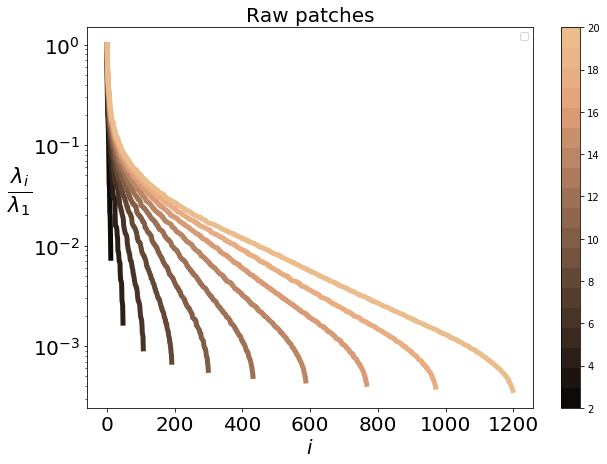

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
max_id = 200
id_start = 1
raw_idx=0
whitened_idx = 3
linewidth = 5
patch_sizes = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
whitening_regs = np.array([0.00001,0.0001,0.001,0.01,0.1,1.,10.])
colors = sns.color_palette("copper", n_colors=len(patch_sizes) , desat=.7)
for i in range(len(patch_sizes)):
    if np.mod(i,2)==0:
        ax.plot(np.sqrt(all_eigvals[i][:,raw_idx]),  color= colors[i], linewidth=linewidth)
        #ax[1].plot(np.sqrt(all_eigvals[i][:,whitened_idx]) , color= colors[i],linewidth=linewidth)

format_ax(ax,xlabel='$i$', ylabel= '$\\frac{\lambda_i}{\lambda_1}$', title = 'Raw patches', labelsize=20, x_ticks_format = None)
#format_ax(ax[1],xlabel='$i$', ylabel= '$\\frac{\lambda_i}{\lambda_1}$', title = 'Whitened patches', labelsize=20, x_ticks_format = None)
norm = mpl.colors.Normalize(vmin=2, vmax=patch_sizes[-1], clip=False)
my_cmap = mpl.colors.ListedColormap(colors.as_hex())
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=my_cmap))

ax.set_yscale('log') 
#ax[1].set_yscale('linear')  
ax.legend()
save('spectrum_patches')

# Covariance dimension

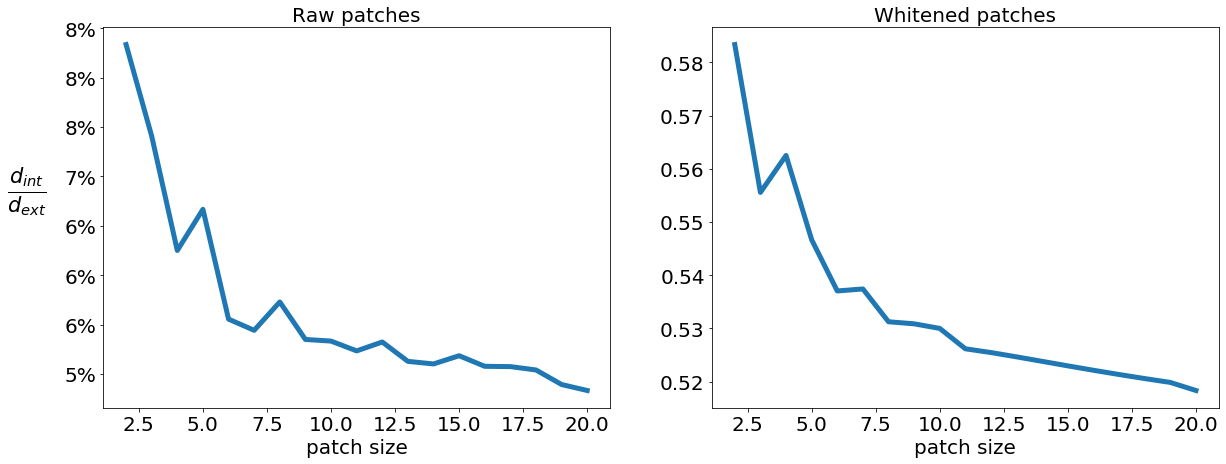

In [6]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
# params
max_id = 100
raw_idx=0
whitened_idx = 3
linewidth = 5.
thresh = 0.1

# computing intrinc dims
all_dims = [ pa.cov_dimension(all_eigvals[i], thresh) for i in range(len(patch_sizes))]
all_dims = np.array(all_dims)

# plot
ax[0].plot(np.array(patch_sizes),all_dims[:,raw_idx],label = str(patch_sizes[i]), linewidth = linewidth )
ax[1].plot(np.array(patch_sizes),all_dims[:,whitened_idx],label = str(patch_sizes[i]), linewidth = linewidth)

format_ax(ax[0],xlabel='patch size', ylabel= '$\\frac{d_{int}}{d_{ext}}$', title = 'Raw patches', labelsize=20)
format_ax(ax[1],xlabel='patch size', ylabel= '', title = 'Whitened patches', labelsize=20, y_ticks_format=None)

save('intrinsic_dims')

# Intrinsic dimension
We use the estimator in https://www.stat.berkeley.edu/users/bickel/mldim.pdf

$d_{int} =  \frac{1}{N} \sum_{n=1}^N  d_{loc}(X_i) $

where $d_{loc}(X_i)$ is the local instrinsic dimension of patch $X_i$ based on the $K$ nearest neigbors.

$d_{loc}(X_i) =   \left(   \frac{1}{K-1} \sum_{m=1}^{K-1}\log(\frac{ dist_{NN_k}(X_i)  }{ dist_{NN_m}( X_i) }  )  \right)^{-1} $

$dist_{NN_m}(X_i)$ is the distance between $X_i$ and it's $m$-th nearest neigbor. 


In [4]:

        
dataset = 'imagenet32'
start_file_name = 'k_nns_'+dataset+'_patchsize'
imagnet32_int_dims_LS  = load_K_nns(root, 'data', start_file_name)


dataset = 'cifar10'
whitening_reg = -1
start_file_name = 'k_nns_'+dataset + '_whitening_reg_'+str(whitening_reg)
cifar10_int_dims_LS  = load_K_nns(root, 'data', start_file_name)


dataset = 'imagenet32'
whitening_reg = 0.0001
start_file_name = 'k_nns_'+dataset + '_whitening_reg_'+str(whitening_reg)
reg_imagnet32_int_dims_LS  = load_K_nns(root, 'data', start_file_name)

dataset = 'cifar10'
whitening_reg = 0.0001
start_file_name = 'k_nns_'+dataset + '_whitening_reg_'+str(whitening_reg)
reg_cifar10_int_dims_LS  = load_K_nns(root, 'data', start_file_name)


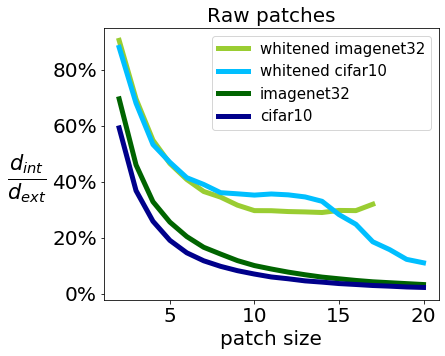

In [5]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
# params
max_id = 100
raw_idx=0
whitened_idx = 3
linewidth = 5.
thresh = 0.2
K_max = 2000
# plot
patch_sizes = []

colors = [ 'darkgreen', 'yellowgreen','darkblue', 'deepskyblue']
ext_dims = reg_imagnet32_int_dims_LS['patch_size']**2*3
ax.plot(reg_imagnet32_int_dims_LS['patch_size'],reg_imagnet32_int_dims_LS['Idim']/ext_dims, label = 'whitened imagenet32', color = colors[1], linewidth = linewidth)

ext_dims = reg_cifar10_int_dims_LS['patch_size']**2*3
ax.plot(reg_cifar10_int_dims_LS['patch_size'],reg_cifar10_int_dims_LS['Idim']/ext_dims, label='whitened cifar10', color = colors[3], linewidth = linewidth)

ext_dims = imagnet32_int_dims_LS['patch_size']**2*3
ax.plot(imagnet32_int_dims_LS['patch_size'],imagnet32_int_dims_LS['Idim']/ext_dims, label = 'imagenet32', color = colors[0], linewidth = linewidth)

ext_dims = cifar10_int_dims_LS['patch_size']**2*3
ax.plot(cifar10_int_dims_LS['patch_size'],cifar10_int_dims_LS['Idim']/ext_dims, label='cifar10', color = colors[2], linewidth = linewidth)


format_ax(ax,xlabel='patch size', ylabel= '$\\frac{d_{int}}{d_{ext}}$', title = 'Raw patches', labelsize=20)
ax.yaxis.set_label_coords(-0.23, 0.35)
ax.legend(fontsize = 15)
#save('intrinsic_dims')

# Topographical ordering of patches

Based on work in http://amsdottorato.unibo.it/9101/     page 78 figure 2.16

In [20]:

dataset = 'cifar10'
device = 'cuda'
whitening_reg = 0.001
file_name = 'patches_k_nns_'+dataset+'_whitening_reg_'+str(whitening_reg)
save_file = os.path.join('data', file_name)
if not os.path.exists(save_file):
    cifar10_patches  = get_patches_nns_from_file(root,file_name)
    with open(save_file, 'wb') as f:
        pickle.dump(cifar10_patches, f)
else:
    with open(save_file, 'rb') as f:
        cifar10_patches = pickle.load(f)




In [21]:
M = 41
patches =  torch.from_numpy(cifar10_patches[0]['patches']).to(device)
K_nns = torch.from_numpy(cifar10_patches[0]['K_nns']).to(device)
K_nn_dist = torch.from_numpy(cifar10_patches[0]['K_nn_dist']).to(device)
start_patch = 0
indicies = pa.compute_topological_order(start_patch,K_nns,M, stride=1,NN=0)

In [22]:
image = build_topographical_image(patches, indicies)
image = image.transpose(1,2,0)

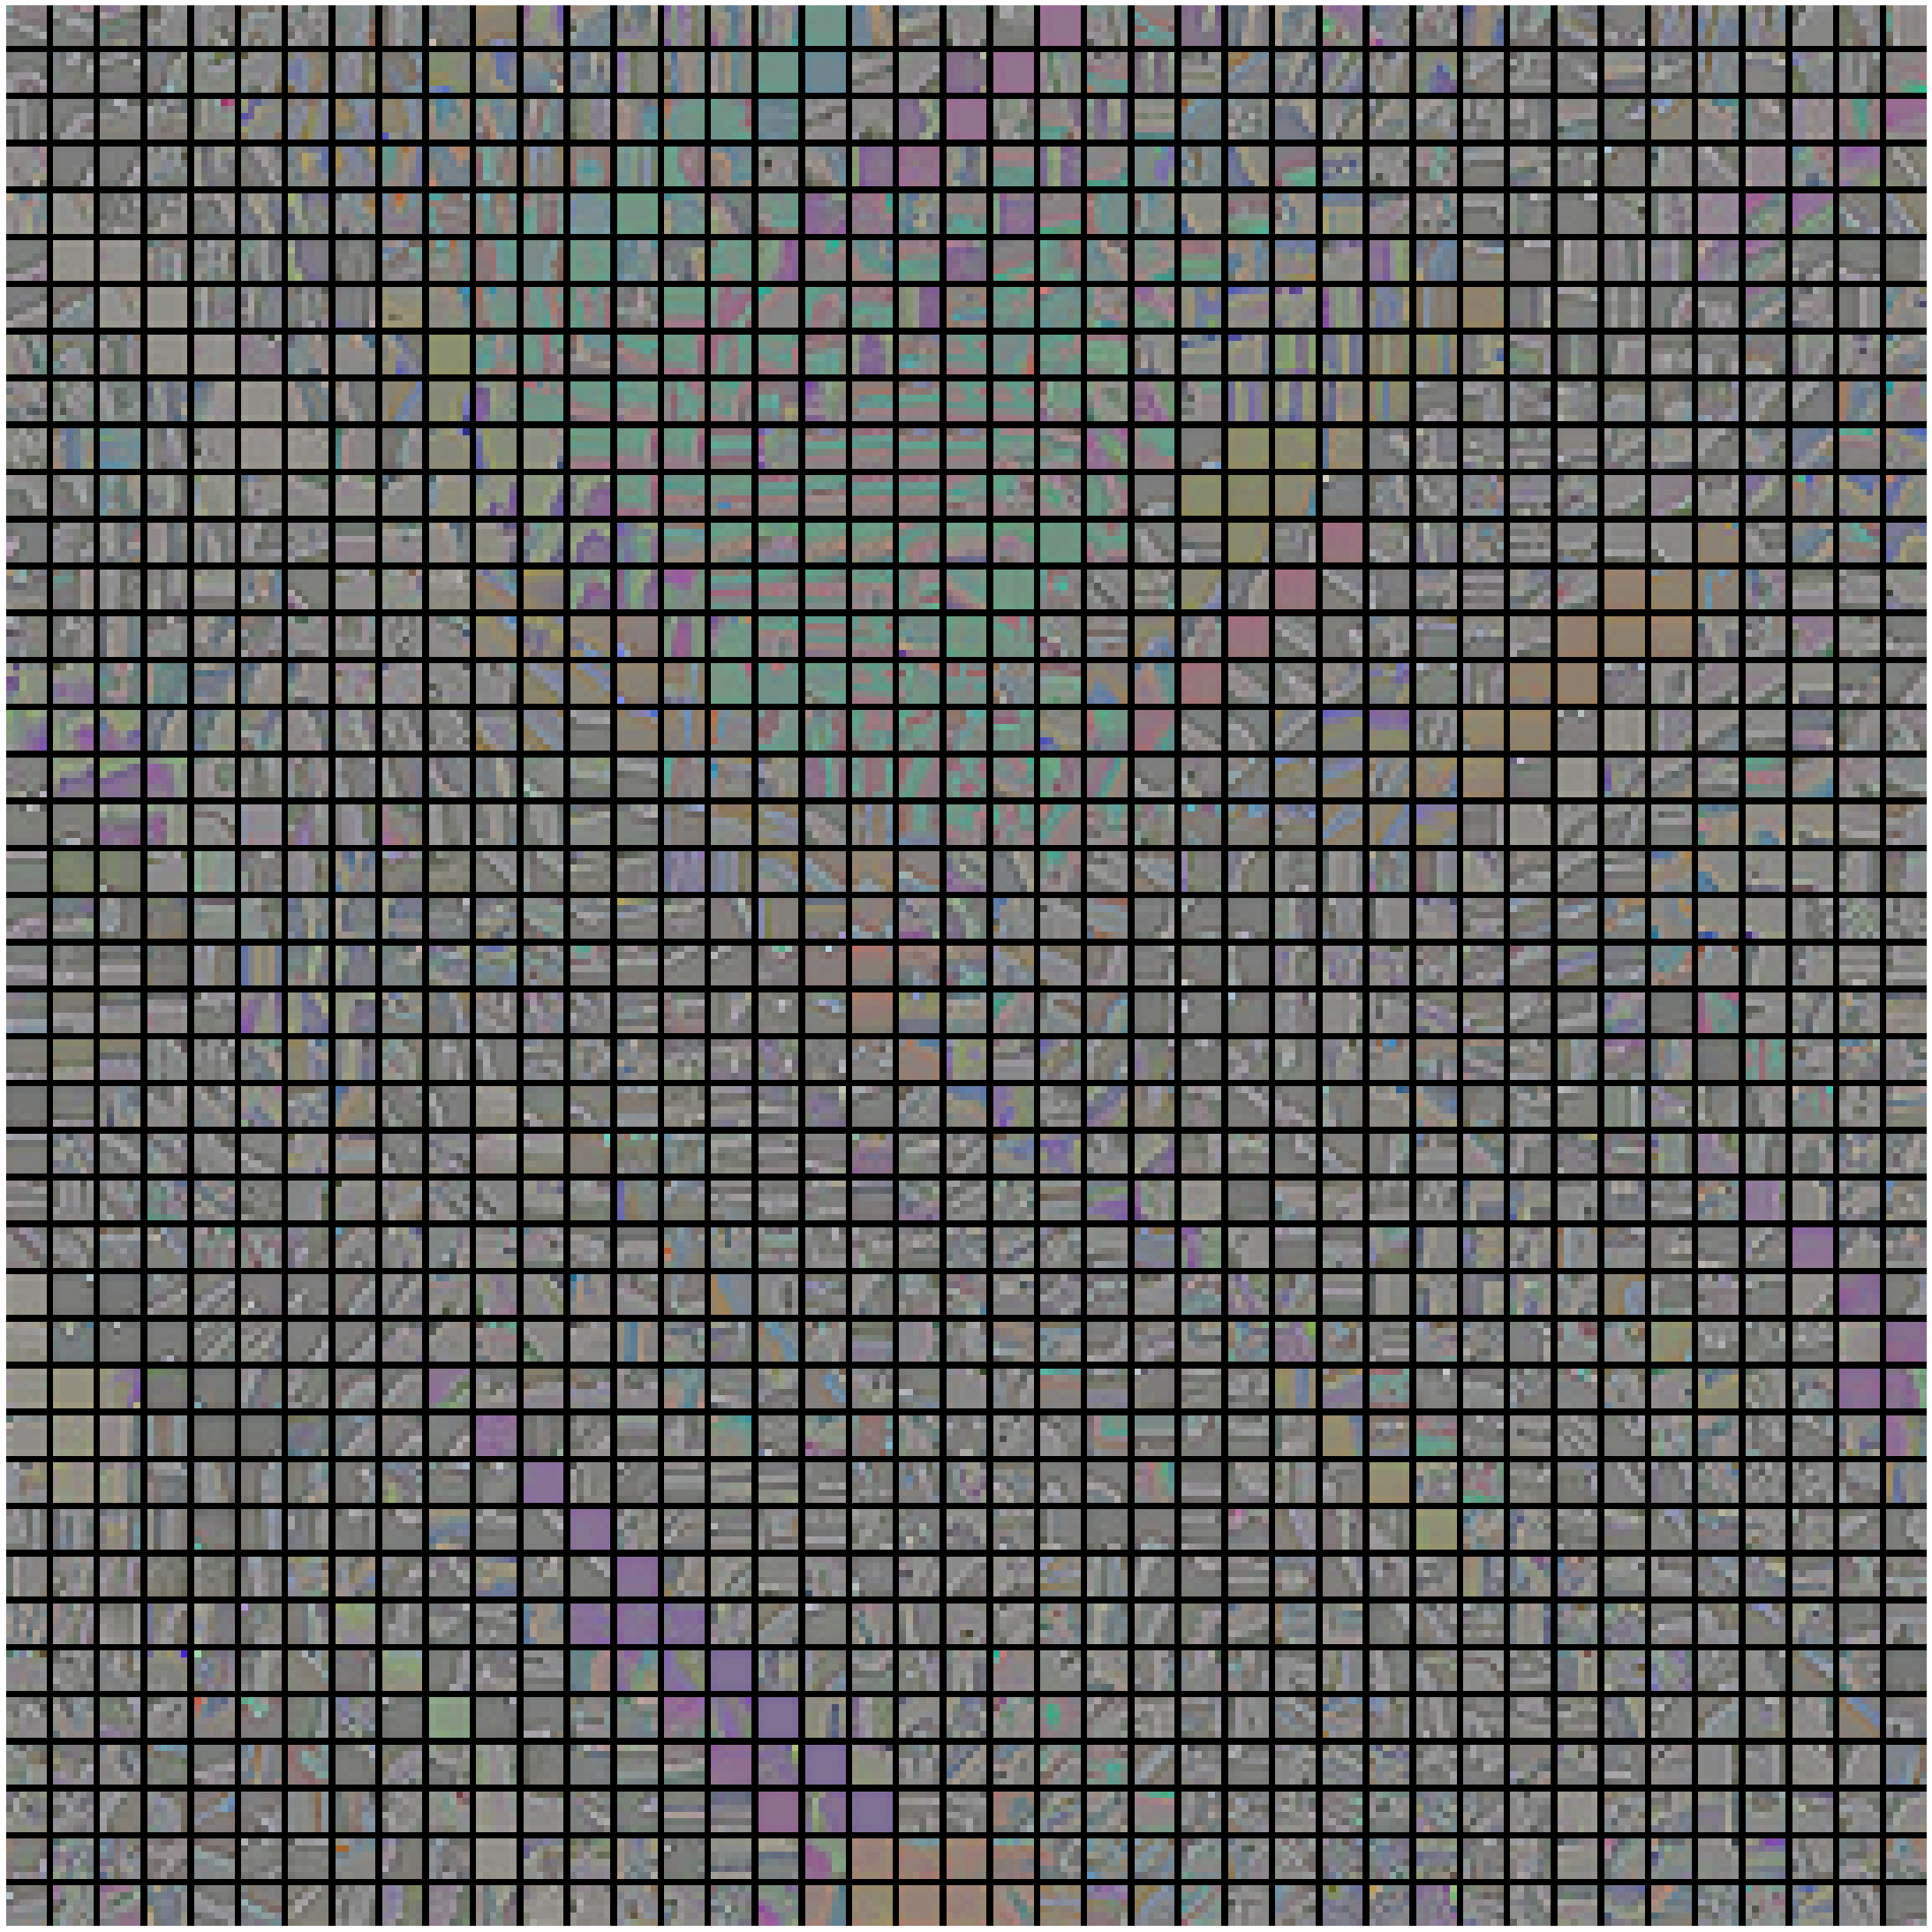

In [23]:
plt.figure(figsize = (40, 40))
plt.axis("off")
plt.imshow(image, interpolation = 'nearest')

save('topographical_order_more_patches')
plt.show()

# Topographical ordering of patches

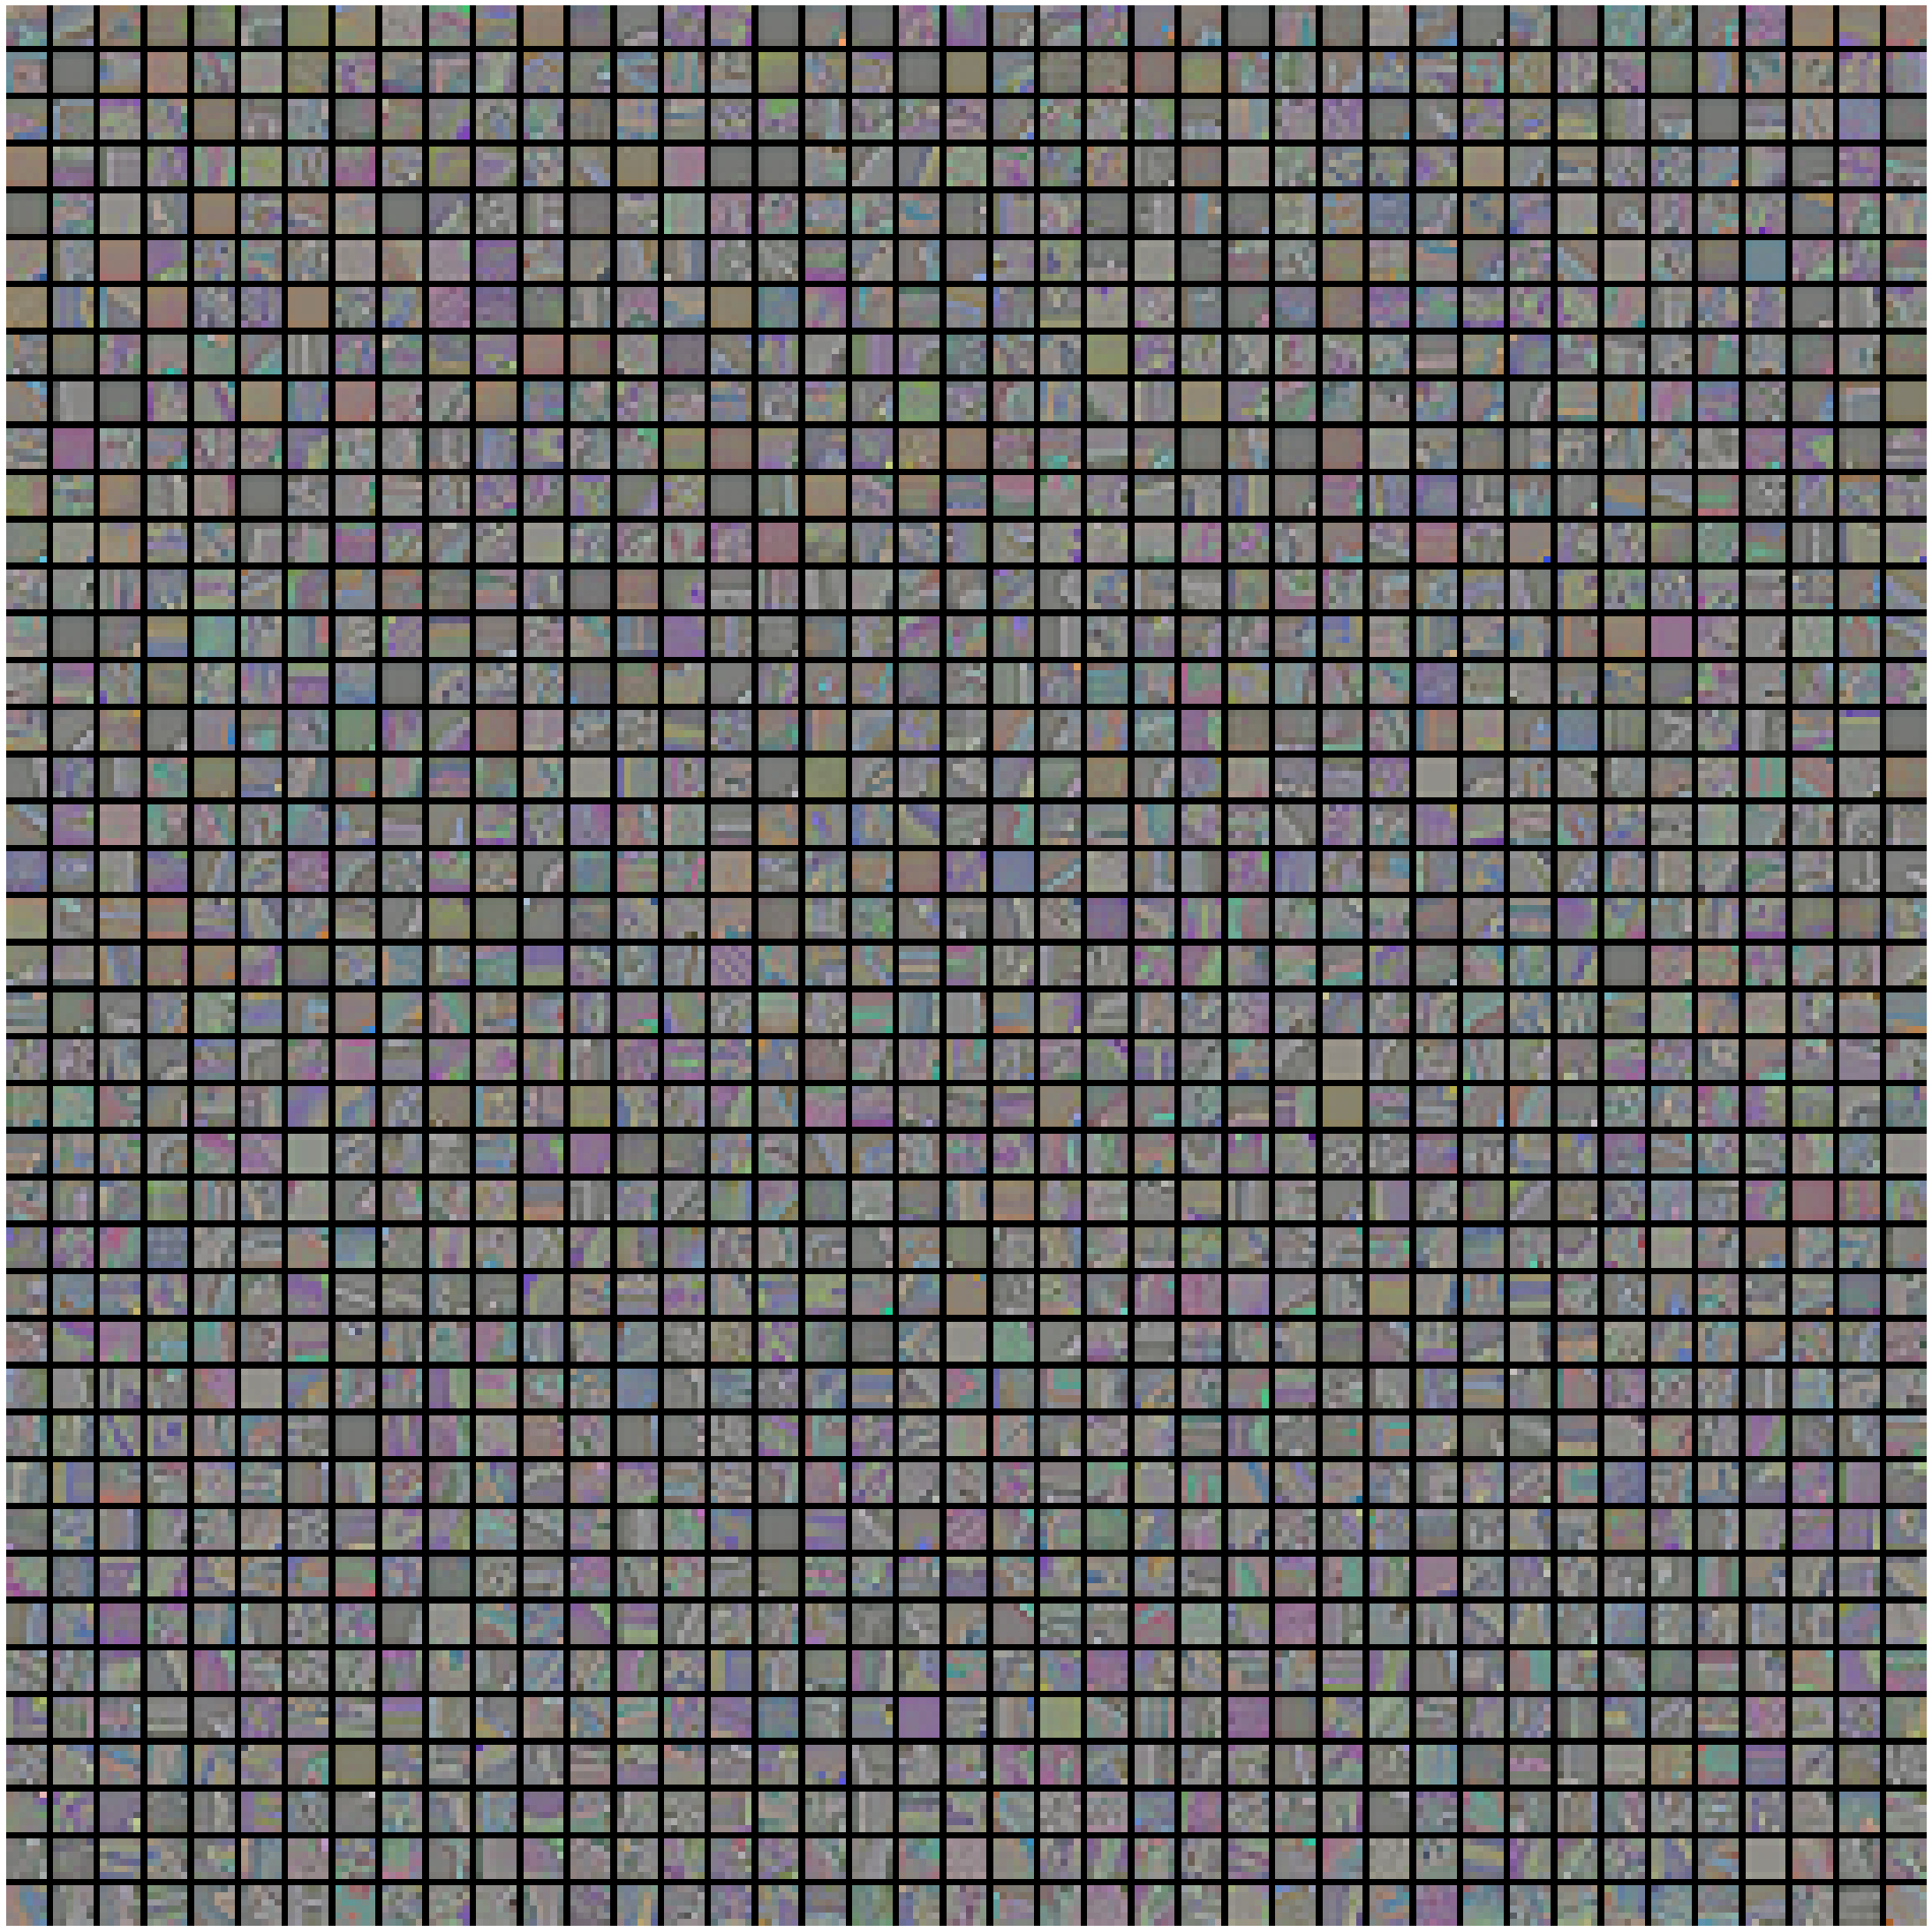

In [13]:
ran_indicies = np.array(range(M**2)).reshape(M,M)
image = build_topographical_image(patches, ran_indicies)
image = image.transpose(1,2,0)


plt.figure(figsize = (40, 40))
plt.axis("off")
plt.imshow(image, interpolation = 'nearest')

save('random_order_more_patches')
plt.show()